In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.callbacks import EarlyStopping,Callback,ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.constraints import max_norm

from scipy import special
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 16
k = np.log2(M)
n_channel = 1
#Transmit Power
P=1
#Power splitting ratio
rho = 1
#Power loss of splitter
eps = 1
#variance of antenna noise
w = 1
#rectifier efficiency
eta=1
noise_std = 1
print('number of symbols:',M)


number of symbols: 16


In [4]:
def set_up_train_nn(P,EsNodB):
    
    label = np.random.randint(M,size=N)
    # creating one hot encoded vectors
    data = []
    for i in label:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp)
        # checking data shape
    data = np.array(data)
    print (data.shape)
    es = EarlyStopping(monitor='val_acc',patience=10, verbose=1)
    #callbacks = [EarlyStoppingByAccuracy(monitor='accuracy', value=0.98, verbose=1)]
    # Defined Autoencoder
    input_signal = Input(shape=(M,))
    encoded = Dense(M, activation='relu')(input_signal)
    encoded = Dense(8, activation='relu')(encoded)
    encoded = Dense(4, activation='relu')(encoded)
    
    encoded2 = Dense(2*n_channel, activation='linear')(encoded)

    # Normalize Power
    encoded3 = BatchNormalization(momentum=0,epsilon=1e-6,center=False,scale=False,axis=1)(encoded2)
    
    encoded4 = Lambda(lambda x: x*np.sqrt(P/2))(encoded3)

    #Add antenna noise
    encoded5 = Lambda(lambda x: x+K.random_normal_variable((4096*2,2), 0, 0.5)[0:tf.shape(x)[0],:])(encoded4)

    # Making PD data, and applying noise
    pd_data = Lambda(lambda x: K.sum(K.square(x),axis=1,keepdims=True))(encoded5)

    # Reciever Layer
    decoded = Dense(2, activation='linear')(pd_data)
    decoded = Dense(4, activation='relu')(decoded)
    decoded = Dense(8, activation='relu')(decoded)
    decoded1 = Dense(M, activation='softmax')(decoded)
    autoencoder = Model(input_signal, decoded1)

    adam = Adam(lr=0.095)
    epochs=200
   
    
    autoencoder.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])
    

    # traning auto encoder
    history = autoencoder.fit(data, data,epochs=epochs,batch_size=4096,callbacks=[es],validation_split=0.3)
    
    
    # list all data in history
    print(history.history.keys())
    
    results = autoencoder.evaluate(data, data, batch_size=2048)
    print('test loss, test acc:', results)

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # making encoder from full autoencoder
    encoder = Model(input_signal, encoded4)
    
    
    # for plotting learned consteallation diagram

    scatter_plot = []
    for i in range(0,M):
        temp = np.zeros(M)
        temp[i] = 1
        scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
    scatter_plot = np.array(scatter_plot)
    print (scatter_plot.shape)
    
    # ploting constellation diagram
    
    scatter_plot = scatter_plot.reshape(M,2,1)

    plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
    #plt.axis((-2,2,-2,2))
    plt.grid()
    #plt.title('Splitting Receiver: rho = '+str(rho)+' P = '+str(P))
    plt.xlabel('I Axis')
    plt.ylabel('Q Axis')
    plt.show()
    #p_av = np.sum(np.square(scatter_plot),axis=1)
    #print(sum(p_av)/16)
    
    return autoencoder

(38000, 16)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 26600 samples, validate on 11400 samples
Epoch 1/200
26600/26600 [==============================] - 6s 231us/step - loss: 2.6038 - acc: 0.1014 - val_loss: 2.4570 - val_acc: 0.1198
Epoch 2/200
26600/26600 [==============================] - 0s 11us/step - loss: 2.3625 - acc: 0.1301 - val_loss: 2.3126 - val_acc: 0.1302
Epoch 3/200
26600/26600 [==============================] - 0s 10us/step - loss: 2.3279 - acc: 0.1314 - val_loss: 2.3163 - val_acc: 0.1250
Epoch 4/200
26600/26600 [==============================] - 0s 9us/step - loss: 2.3132 - acc: 0.1387 - val_loss: 2.3110 - val_acc: 0.1370
Epoch 5/200
26600/26600 [==============================] - 0s 10us/step - loss: 2.3096 - acc: 0.1455 - val_loss: 2.3101 - val_acc: 0.1529
Epoch 6/200
26600/26600 [==============================] - 0s 9us/step - loss: 2.3086 - acc: 0.1469 - val_loss: 2.3068 - val_acc

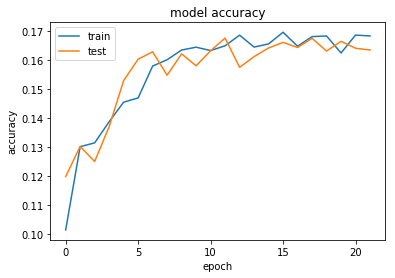

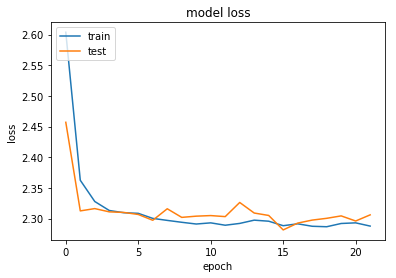

(16, 1, 2)


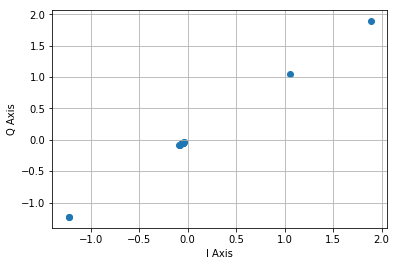

SNR: 0 SER: 0.8433421052631579 Theor_SER: 0.8232078436042176
(44000, 16)
Train on 30799 samples, validate on 13201 samples
Epoch 1/200
30799/30799 [==============================] - 5s 149us/step - loss: 2.7388 - acc: 0.0867 - val_loss: 2.5868 - val_acc: 0.1232
Epoch 2/200
30799/30799 [==============================] - 0s 9us/step - loss: 2.5639 - acc: 0.1316 - val_loss: 2.5046 - val_acc: 0.1466
Epoch 3/200
30799/30799 [==============================] - 0s 11us/step - loss: 2.4401 - acc: 0.1590 - val_loss: 2.3671 - val_acc: 0.1926
Epoch 4/200
30799/30799 [==============================] - 0s 11us/step - loss: 2.2553 - acc: 0.2154 - val_loss: 2.1848 - val_acc: 0.2184
Epoch 5/200
30799/30799 [==============================] - 0s 10us/step - loss: 2.1039 - acc: 0.2392 - val_loss: 2.0602 - val_acc: 0.2353
Epoch 6/200
30799/30799 [==============================] - 0s 9us/step - loss: 1.9906 - acc: 0.2486 - val_loss: 1.9772 - val_acc: 0.2331
Epoch 7/200
30799/30799 [=========================

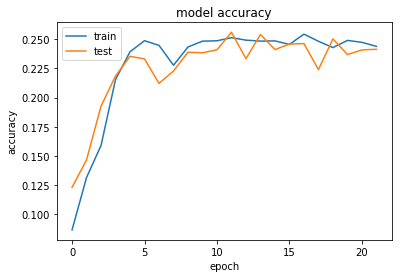

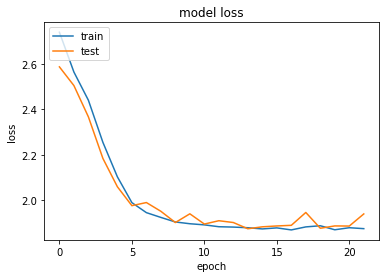

(16, 1, 2)


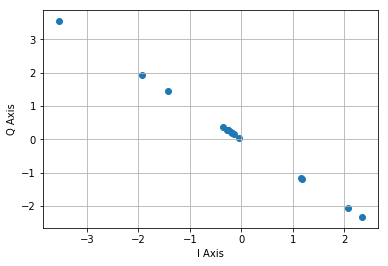

SNR: 6 SER: 0.7482045454545454 Theor_SER: 0.712087050228903
(70000, 16)
Train on 49000 samples, validate on 21000 samples
Epoch 1/200
49000/49000 [==============================] - 7s 140us/step - loss: 3.2701 - acc: 0.0869 - val_loss: 2.5712 - val_acc: 0.1535
Epoch 2/200
49000/49000 [==============================] - 1s 11us/step - loss: 2.3478 - acc: 0.2049 - val_loss: 2.1403 - val_acc: 0.2175
Epoch 3/200
49000/49000 [==============================] - 0s 10us/step - loss: 2.0528 - acc: 0.2290 - val_loss: 1.9741 - val_acc: 0.2079
Epoch 4/200
49000/49000 [==============================] - 1s 11us/step - loss: 1.9176 - acc: 0.2557 - val_loss: 1.8566 - val_acc: 0.2762
Epoch 5/200
49000/49000 [==============================] - 1s 11us/step - loss: 1.8338 - acc: 0.2824 - val_loss: 1.7832 - val_acc: 0.3064
Epoch 6/200
49000/49000 [==============================] - 1s 11us/step - loss: 1.8302 - acc: 0.2820 - val_loss: 1.7869 - val_acc: 0.2890
Epoch 7/200
49000/49000 [========================

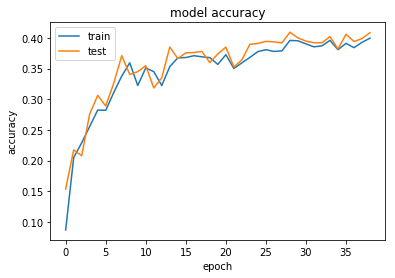

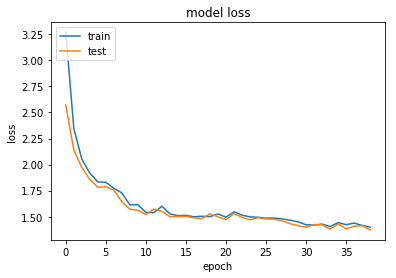

(16, 1, 2)


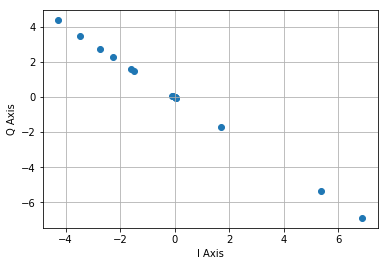

SNR: 12 SER: 0.5588714285714286 Theor_SER: 0.5075803579279314
(40000, 16)
Train on 28000 samples, validate on 12000 samples
Epoch 1/200
28000/28000 [==============================] - 6s 212us/step - loss: 3.2042 - acc: 0.0626 - val_loss: 2.7771 - val_acc: 0.0593
Epoch 2/200
28000/28000 [==============================] - 0s 8us/step - loss: 2.7757 - acc: 0.0624 - val_loss: 2.7743 - val_acc: 0.0623
Epoch 3/200
28000/28000 [==============================] - 0s 8us/step - loss: 2.7744 - acc: 0.0615 - val_loss: 2.7741 - val_acc: 0.0586
Epoch 4/200
28000/28000 [==============================] - 0s 7us/step - loss: 2.7737 - acc: 0.0621 - val_loss: 2.7738 - val_acc: 0.0616
Epoch 5/200
28000/28000 [==============================] - 0s 15us/step - loss: 2.7736 - acc: 0.0633 - val_loss: 2.7740 - val_acc: 0.0586
Epoch 6/200
28000/28000 [==============================] - 0s 11us/step - loss: 2.7733 - acc: 0.0641 - val_loss: 2.7735 - val_acc: 0.0593
Epoch 7/200
28000/28000 [=========================

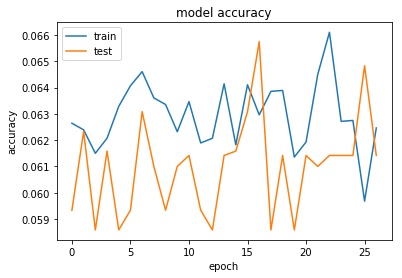

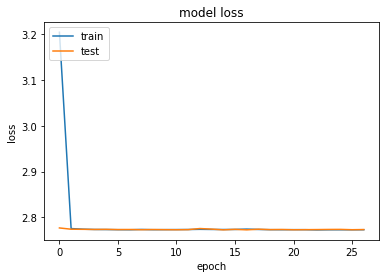

(16, 1, 2)


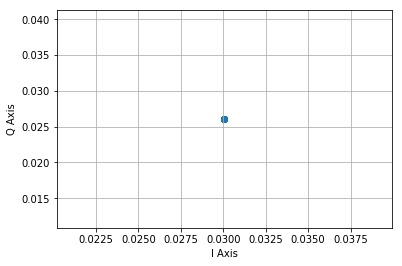

SNR: 16 SER: 0.9332 Theor_SER: 0.3123019621637889
(34000, 16)
Train on 23800 samples, validate on 10200 samples
Epoch 1/200
23800/23800 [==============================] - 4s 164us/step - loss: 3.8288 - acc: 0.0738 - val_loss: 2.7943 - val_acc: 0.0781
Epoch 2/200
23800/23800 [==============================] - 0s 9us/step - loss: 2.6492 - acc: 0.1264 - val_loss: 2.5235 - val_acc: 0.1284
Epoch 3/200
23800/23800 [==============================] - 0s 8us/step - loss: 2.4933 - acc: 0.1240 - val_loss: 2.4738 - val_acc: 0.1289
Epoch 4/200
23800/23800 [==============================] - 0s 9us/step - loss: 2.4545 - acc: 0.1224 - val_loss: 2.4402 - val_acc: 0.1305
Epoch 5/200
23800/23800 [==============================] - 0s 9us/step - loss: 2.4280 - acc: 0.1258 - val_loss: 2.4227 - val_acc: 0.1472
Epoch 6/200
23800/23800 [==============================] - 0s 9us/step - loss: 2.4165 - acc: 0.1293 - val_loss: 2.4177 - val_acc: 0.1251
Epoch 7/200
23800/23800 [==============================] - 0s 8u

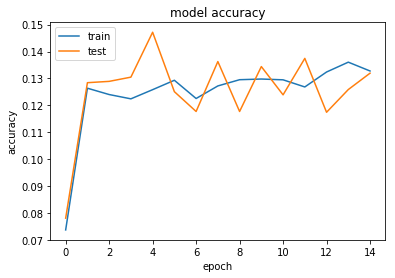

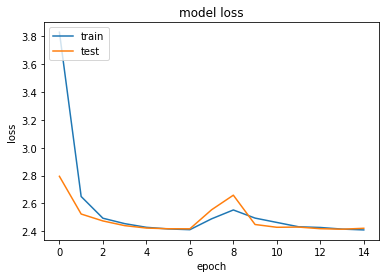

(16, 1, 2)


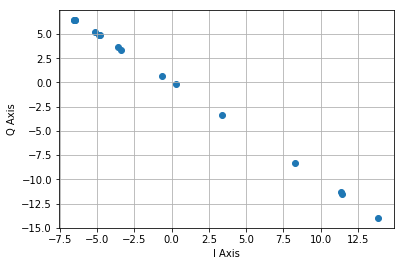

SNR: 20 SER: 0.8625 Theor_SER: 0.11723145012290671
(36000, 16)
Train on 25200 samples, validate on 10800 samples
Epoch 1/200
25200/25200 [==============================] - 5s 201us/step - loss: 12.5278 - acc: 0.0633 - val_loss: 6.2328 - val_acc: 0.0639
Epoch 2/200
25200/25200 [==============================] - 0s 11us/step - loss: 3.0636 - acc: 0.0907 - val_loss: 2.7978 - val_acc: 0.0823
Epoch 3/200
25200/25200 [==============================] - 0s 11us/step - loss: 2.6202 - acc: 0.1254 - val_loss: 2.5988 - val_acc: 0.1265
Epoch 4/200
25200/25200 [==============================] - 0s 10us/step - loss: 2.5799 - acc: 0.1259 - val_loss: 2.5862 - val_acc: 0.1156
Epoch 5/200
25200/25200 [==============================] - 0s 11us/step - loss: 2.5578 - acc: 0.1264 - val_loss: 2.5666 - val_acc: 0.1223
Epoch 6/200
25200/25200 [==============================] - 0s 10us/step - loss: 2.5493 - acc: 0.1276 - val_loss: 2.5589 - val_acc: 0.1221
Epoch 7/200
25200/25200 [==============================] 

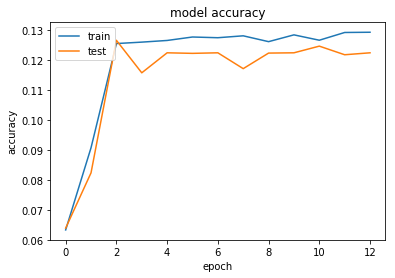

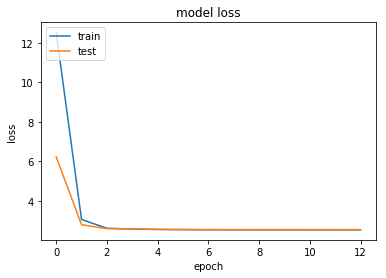

(16, 1, 2)


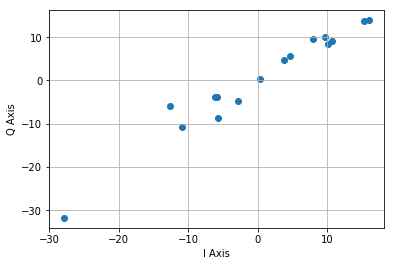

SNR: 24 SER: 0.8734722222222222 Theor_SER: 0.014111651848117142
(38000, 16)
Train on 26600 samples, validate on 11400 samples
Epoch 1/200
26600/26600 [==============================] - 6s 217us/step - loss: 14.8770 - acc: 0.0643 - val_loss: 14.3659 - val_acc: 0.0631
Epoch 2/200
26600/26600 [==============================] - 0s 17us/step - loss: 14.9821 - acc: 0.0618 - val_loss: 15.1004 - val_acc: 0.0631
Epoch 3/200
26600/26600 [==============================] - 0s 15us/step - loss: 14.8096 - acc: 0.0618 - val_loss: 13.3371 - val_acc: 0.0631
Epoch 4/200
26600/26600 [==============================] - 0s 12us/step - loss: 10.4808 - acc: 0.0911 - val_loss: 3.0193 - val_acc: 0.0620
Epoch 5/200
26600/26600 [==============================] - 0s 8us/step - loss: 3.5924 - acc: 0.0698 - val_loss: 2.7997 - val_acc: 0.0573
Epoch 6/200
26600/26600 [==============================] - 0s 9us/step - loss: 2.7913 - acc: 0.0645 - val_loss: 2.7961 - val_acc: 0.0625
Epoch 7/200
26600/26600 [===============

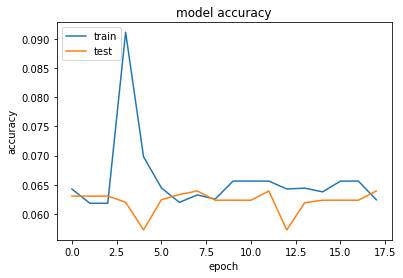

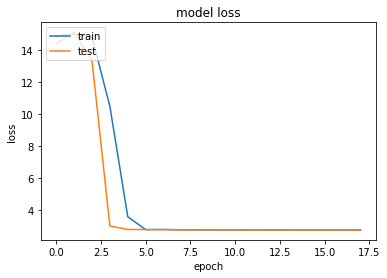

(16, 1, 2)


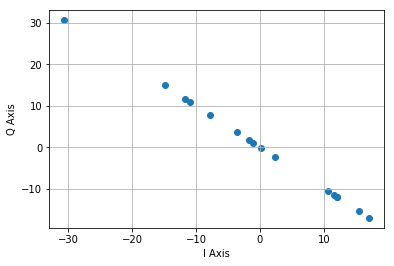

SNR: 25 SER: 0.9383947368421053 Theor_SER: 0.00597813169126268


In [5]:
# Calculating SER from -4dB to 14dB SNR
EsNodB_range = [0,6,12,16,20,24,25]
N_array = [38000,44000,70000,40000,34000,36000,38000]
#EsNodB_range = EsNodB_range[-3:]
#N_array = N_array[-3:]
ser = [None]*len(EsNodB_range)
theor_ser = [None]*len(EsNodB_range)

for n in range(0,len(EsNodB_range)):
    
    
    EsNo=10.0**(EsNodB_range[n]/10.0)
    P = EsNo*(noise_std**2)
    no_errors = 0
    
    N = N_array[n]
    autoencoder = set_up_train_nn(P,EsNodB_range[n])
    
       
    test_data = []
    test_label = np.random.randint(M,size=N)
    for i in test_label:
        temp = np.zeros(M)
        temp[i] = 1
        test_data.append(temp)

    test_data = np.array(test_data)
    
    pred_final_signal = autoencoder.predict(test_data)
    pred_output = np.argmax(pred_final_signal,axis=1)
    
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ser[n] = (no_errors/N).astype('float64') 
    
    theor_ser[n] = (15/16)*special.erfc(np.sqrt(EsNo/85))
    
    print ('SNR:',EsNodB_range[n],'SER:',ser[n],'Theor_SER:',theor_ser[n])

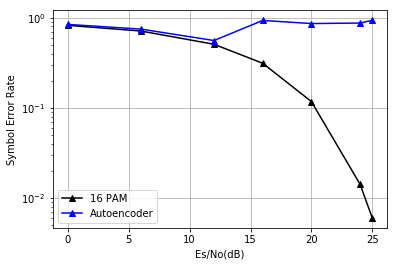

In [6]:
# ploting BER curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EsNodB_range, theor_ser, 'k^-',label='16 PAM')
plt.plot(EsNodB_range, ser, 'b^-',label='Autoencoder')
plt.yscale('log')
plt.xlabel('Es/No(dB)')
plt.ylabel('Symbol Error Rate')
#plt.ylim((10e-3,10e0))
plt.grid()
plt.legend(loc='best',ncol = 1)
plt.show()